In [104]:
from keras import backend as K

Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd

In [106]:
import keras

# Indodax Data Retrieval

In [3]:
import requests
import datetime
import pytz
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

In [43]:
root_uri_trade_api = 'https://indodax.com/api'
root_uri_chart_api = 'https://indodax.com/tradingview/history'
#?symbol=BTCIDR&resolution=15&from=1546489788&to=1547785848'
chart_currency = 'BTCIDR'
period = '5'
time_begin = int(datetime.datetime(2018, 1, 1).timestamp())
time_end = int(datetime.datetime(2018, 6, 1).timestamp())
chart_query = '?symbol={}&resolution={}&from={}&to={}'.format(chart_currency, period, time_begin, time_end)

r = requests.get(root_uri_chart_api + chart_query)
price = pd.DataFrame({
    'open': r.json()['o'],
    'close': r.json()['c'],
    'high': r.json()['h'],
    'low': r.json()['l'],
    'volume': r.json()['v']
# }, index=list(map(lambda t: (datetime.datetime.utcfromtimestamp(t) + datetime.timedelta(hours=7)).strftime('%d/%m %H.%M'), r.json()['t'])))
}, index=list(map(lambda t: (datetime.datetime.utcfromtimestamp(t) + datetime.timedelta(hours=7)), r.json()['t'])))
len(price)

43489

C:\Users\yerla\.conda\envs\ml\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


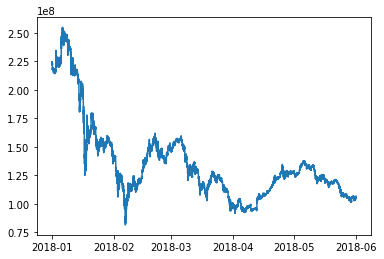

In [44]:
plt.plot(price.close)

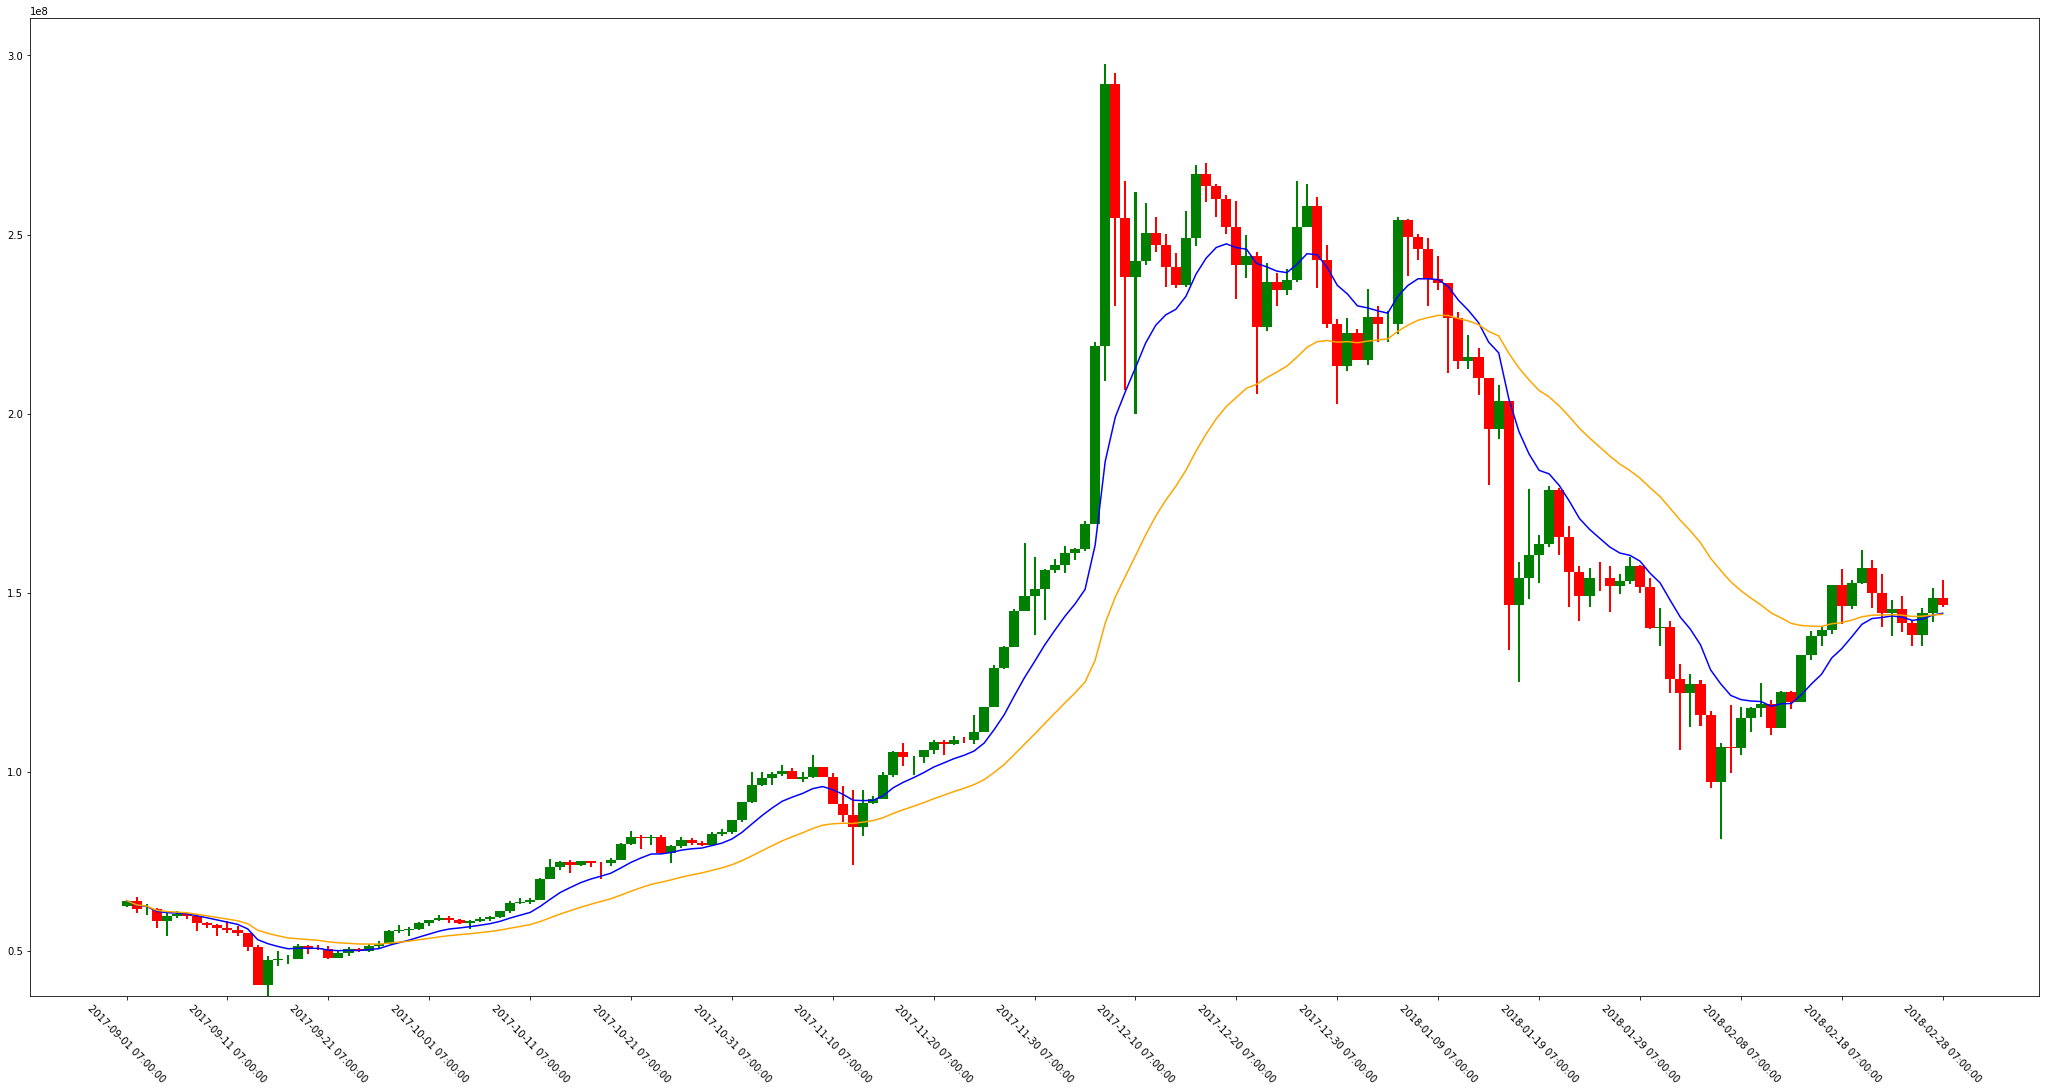

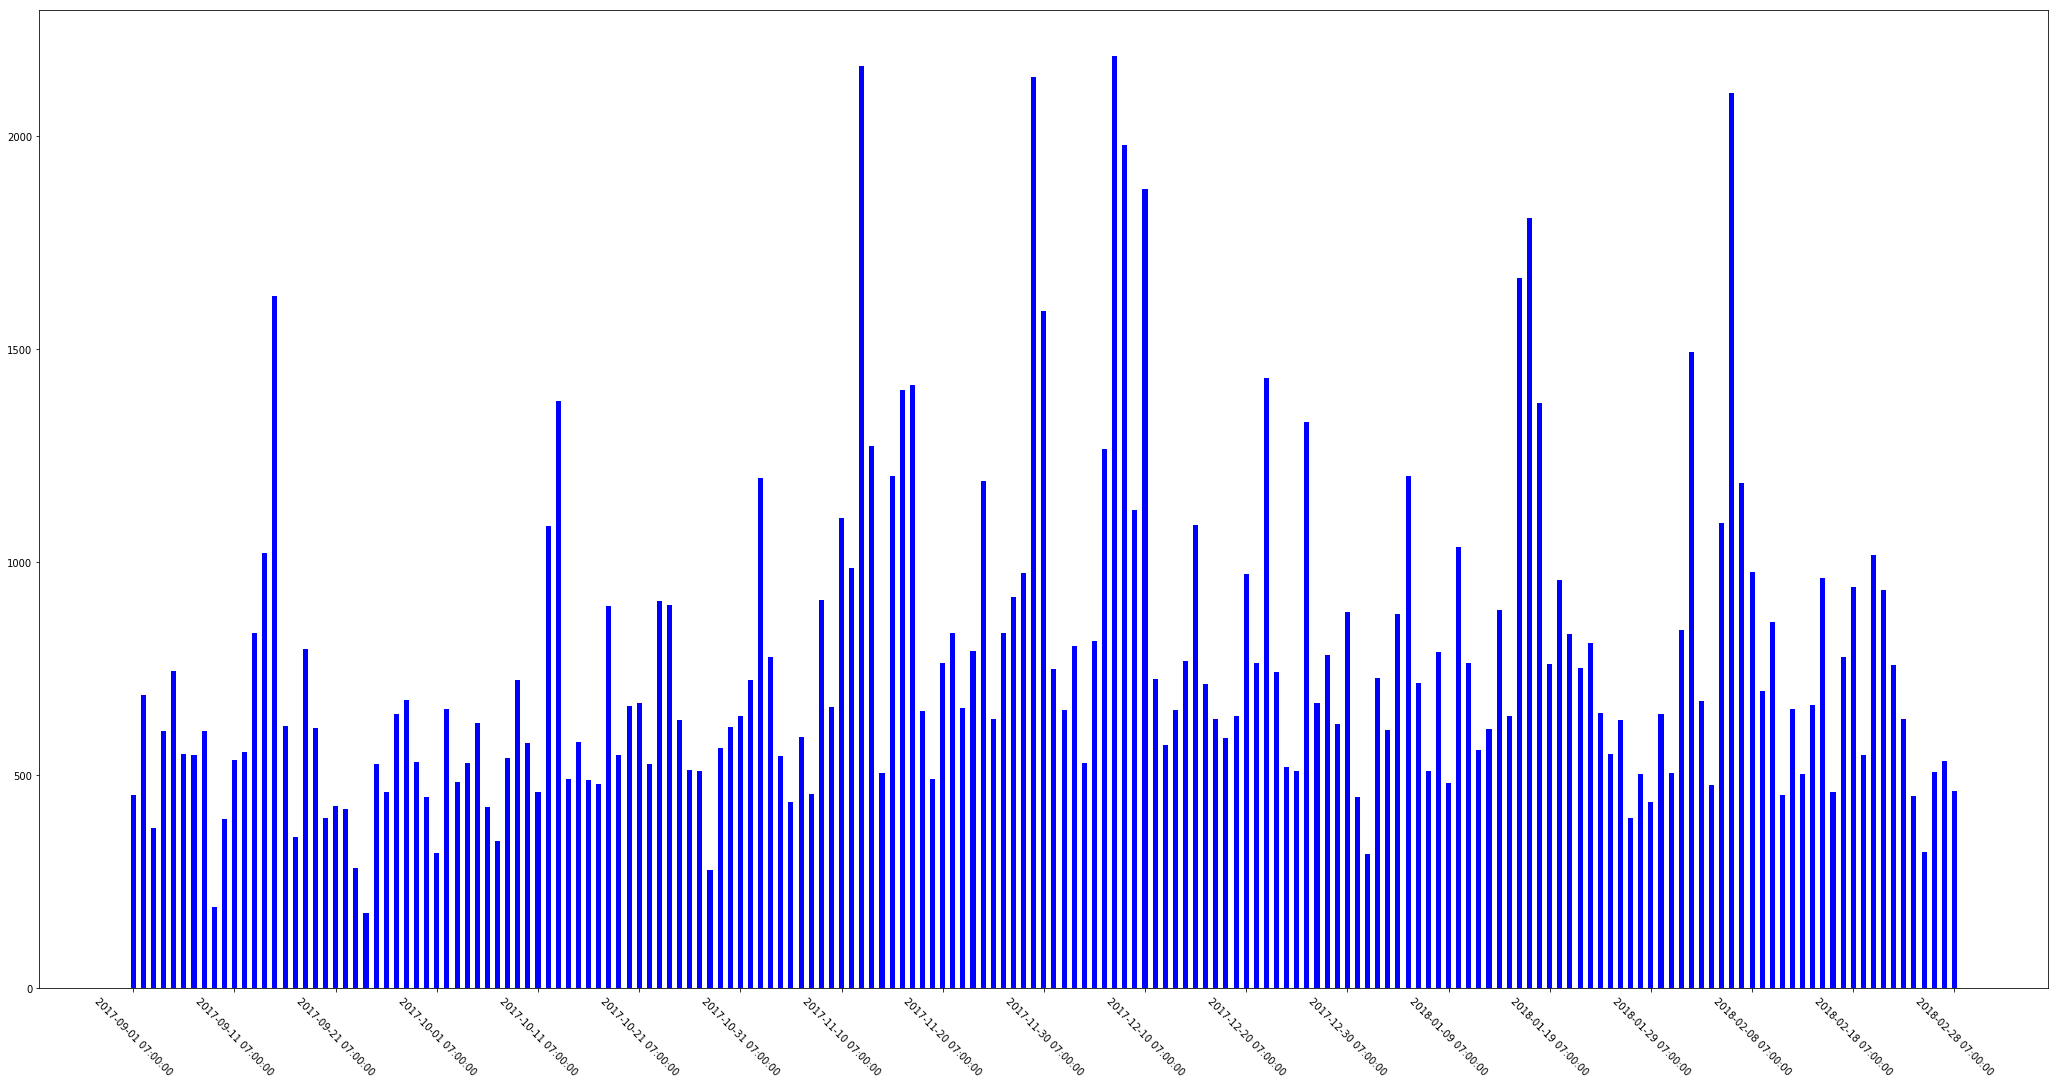

In [401]:
candle_color = lambda o, c: 'g' if c >= o else 'r'
fig_w = len(price.open)//5
fig_h = fig_w // 2
plt.figure(figsize=(fig_w, fig_h))
plt.bar( [i for i in range(len(price.open))],
        [abs(c-o) for c,o in zip(price.close, price.open)],
        [1 for i in range(len(price.open))],
        [min(c, o) for c,o in zip(price.close, price.open)],
        color=[candle_color(o, c) for c,o in zip(price.close, price.open)]
)
plt.bar( [i for i in range(len(price.high))],
        [h-l for h,l in zip(price.high, price.low)],
        [.2 for i in range(len(price.high))],
        [l for l in price.low],
        color=[candle_color(o, c) for c,o in zip(price.close, price.open)]
)
plt.plot([i for i in range(len(price.high))], price.close.ewm(span=10).mean(), color='blue')
plt.plot([i for i in range(len(price.high))], price.close.ewm(span=30).mean(), color='orange')
ax = plt.gca()
ax.set_xticks([i for i in range(len(price.index))][::10])
ax.set_xticklabels(price.index[::10], rotation=-45)
plt.figure(figsize=(fig_w, fig_h))
plt.bar([i for i in range(len(price.volume))],
        price.volume,
        .5,
        color='blue'
)
ax = plt.gca()
ax.set_xticks([i for i in range(len(price.index))][::10])
ax.set_xticklabels(price.index[::10], rotation=-45)

#use this to visualize
plt.show()

In [45]:
action = []

# weird workaround due to limitation to column name, see below
# HOLD --> 0
# BUY --> -1
# SELL --> 1

close = np.array(price.close)

for i in range(len(price.index)-1):
    current = close[i]
    before = close[i-1]
    after = close[i+1]
    if current * 1.003 < after:
        if before * 1.003 < current:
            action.append(0)
        else:
            action.append(-1)
    elif current > after * 1.003:
        if before > current * 1.003:
            action.append(0)
        else:
            action.append(1)
    else:
        action.append(0)
action.append(0)
action_frame = pd.DataFrame(action).set_index(price.index)

# we need the stock price somehow
action_frame = action_frame.join(price)

# column names change 'Action' to 'low'
# weird workaround due to limitation to column name
# reference : https://www.backtrader.com/docu/pandas-datafeed/pandas-datafeed.html?highlight=pandasdata
action_frame.columns = ['low', 'open', 'close', 'high', 'real_low', 'volume']

In [47]:
len(list(filter(lambda a: a == -1, action)))

3495

In [48]:
len(list(filter(lambda a: a == 0, action)))

36349

In [49]:
len(list(filter(lambda a: a == 1, action)))

3645

# Labeling

In [10]:
close = np.array(price.close)
label = [0 for i in range(len(close))]
profit = [0 for i in range(len(close))]
t_forward = 10
commission = 0.003
min_net_profit = lambda p: p * (1+(2*commission))
for i in range(t_forward, len(price)):
    # sample the future
    sample = np.array([close[i-j] for j in range(5)])
    profit[i-t_forward] = close[t_forward] - sample.mean() - (close[t_forward] * commission) - (close[i] * commission)
    if (sample > min_net_profit(close[i-t_forward])).sum() > 4:
        label[i-t_forward] = -1
        label[i] = 1

### Just the profits

In [6]:
close = np.array(price.close)
profit = [0 for i in range(len(close))]
t_forward = 30
for i in range(t_forward, len(price)):
    # sample the future
    sample = np.array([close[i-j] for j in range(15)])
    profit[i-t_forward] = (sample.mean() - close[i] - (sample.mean() * commission) - (close[i] * commission)) / close[i]

In [181]:
print('buy', len(list(filter(lambda p: p == -1, label))))
print('hold', len(list(filter(lambda p: p == 0, label))))
print('sell', len(list(filter(lambda p: p == 1, label))))

buy 2043
hold 39617
sell 1829


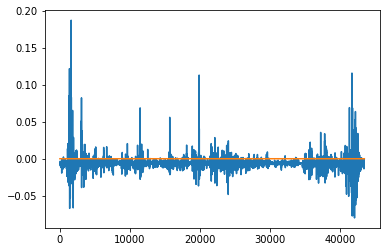

In [7]:
plt.plot(profit)
plt.plot([0 for i in range(len(profit))])

## Label Balancing
More buy

In [182]:
state = 'not buying'
now = 0
for i in range(len(price)-t_forward, -1, -1):
    if state == 'not buying' and label[i] == -1:
        state = 'buying'
        now = close[i]
    if state == 'buying' and label[i] != -1:
        state = 'buy more'
    if state == 'buy more':
        if close[i] <= now:
            now = price.close[i]
            label[i] = -1
        else:
            state = 'not buying'

In [183]:
print('buy', len(list(filter(lambda p: p == -1, label))))
print('hold', len(list(filter(lambda p: p == 0, label))))
print('sell', len(list(filter(lambda p: p == 1, label))))

buy 2611
hold 39103
sell 1775


More sell

In [184]:
state = 'not selling'
now = 0
for i in range(t_forward, len(close)):
    if state == 'not selling' and label[i] == 1:
        state = 'selling'
        now = close[i]
    if state == 'selling' and label[i] != 1:
        state = 'sell more'
    if state == 'sell more':
        if close[i] <= now:
            now = price.close[i]
            label[i] = 1
        else:
            state = 'not selling'

In [185]:
print('buy', len(list(filter(lambda p: p == -1, label))))
print('hold', len(list(filter(lambda p: p == 0, label))))
print('sell', len(list(filter(lambda p: p == 1, label))))

buy 2493
hold 38554
sell 2442


In [186]:
action_frame.low = label

In [6]:
import backtrader as bt
import backtrader.feeds as btfeeds

In [54]:
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # weird workaround due to limitation to column name
        # we take the low column as action
        self.data_action = self.datas[0].low
        # To keep track of pending orders
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
                self.opsize = order.executed.size
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

                gross_pnl = (order.executed.price - self.buyprice) * \
                    self.opsize

                net_pnl = gross_pnl - self.buycomm - order.executed.comm
                self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                         (gross_pnl, net_pnl))


            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # buy!
            if self.data_action[0] == -1:
                self.log('BUY CREATE')
                self.order = self.buy()

        else:
            # sell!
            if self.data_action[0] == 1:
                self.log('SELL CREATE')
                self.order = self.sell()

In [55]:
# data_feed = btfeeds.PandasData(dataname=price, openinterest=None)
data_feed = btfeeds.PandasData(dataname=action_frame, openinterest=None)
#print(data_feed)

cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy)
cerebro.adddata(data_feed)
# cerebro.adddata(action_frame)
cerebro.broker.setcash(1000000000.0)
cerebro.broker.setcommission(commission=commission)

# Print out the starting conditions
startingPortofolio = cerebro.broker.getvalue()
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run()

# Print out the final result
finalPortofolio = cerebro.broker.getvalue()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
print('Profit: %.2f (%.6f%%)' % (finalPortofolio - startingPortofolio, (finalPortofolio - startingPortofolio)/startingPortofolio*100))

Starting Portfolio Value: 1000000000.00
2018-01-01, BUY CREATE
2018-01-01, BUY EXECUTED, Price: 222091000.00, Cost: 222091000.00, Comm 666273.00
2018-01-01, SELL CREATE
2018-01-01, SELL EXECUTED, Price: 224199000.00, Cost: 222091000.00, Comm 672597.00
2018-01-01, OPERATION PROFIT, GROSS 2108000.00, NET 769130.00
2018-01-01, BUY CREATE
2018-01-01, BUY EXECUTED, Price: 223025000.00, Cost: 223025000.00, Comm 669075.00
2018-01-01, SELL CREATE
2018-01-01, SELL EXECUTED, Price: 224502000.00, Cost: 223025000.00, Comm 673506.00
2018-01-01, OPERATION PROFIT, GROSS 1477000.00, NET 134419.00
2018-01-01, BUY CREATE
2018-01-01, BUY EXECUTED, Price: 222106000.00, Cost: 222106000.00, Comm 666318.00
2018-01-01, SELL CREATE
2018-01-01, SELL EXECUTED, Price: 223078000.00, Cost: 222106000.00, Comm 669234.00
2018-01-01, OPERATION PROFIT, GROSS 972000.00, NET -363552.00
2018-01-01, BUY CREATE
2018-01-01, BUY EXECUTED, Price: 222102000.00, Cost: 222102000.00, Comm 666306.00
2018-01-01, SELL CREATE
2018-01-0

2018-01-04, BUY EXECUTED, Price: 220099000.00, Cost: 220099000.00, Comm 660297.00
2018-01-04, SELL CREATE
2018-01-04, SELL EXECUTED, Price: 221500000.00, Cost: 220099000.00, Comm 664500.00
2018-01-04, OPERATION PROFIT, GROSS 1401000.00, NET 76203.00
2018-01-04, BUY CREATE
2018-01-04, BUY EXECUTED, Price: 220356000.00, Cost: 220356000.00, Comm 661068.00
2018-01-04, SELL CREATE
2018-01-04, SELL EXECUTED, Price: 224991000.00, Cost: 220356000.00, Comm 674973.00
2018-01-04, OPERATION PROFIT, GROSS 4635000.00, NET 3298959.00
2018-01-04, BUY CREATE
2018-01-04, BUY EXECUTED, Price: 225801000.00, Cost: 225801000.00, Comm 677403.00
2018-01-04, SELL CREATE
2018-01-04, SELL EXECUTED, Price: 226987000.00, Cost: 225801000.00, Comm 680961.00
2018-01-04, OPERATION PROFIT, GROSS 1186000.00, NET -172364.00
2018-01-04, BUY CREATE
2018-01-04, BUY EXECUTED, Price: 225031000.00, Cost: 225031000.00, Comm 675093.00
2018-01-04, SELL CREATE
2018-01-04, SELL EXECUTED, Price: 226516000.00, Cost: 225031000.00, Com

2018-01-07, SELL CREATE
2018-01-07, SELL EXECUTED, Price: 249089000.00, Cost: 249049000.00, Comm 747267.00
2018-01-07, OPERATION PROFIT, GROSS 40000.00, NET -1454414.00
2018-01-07, BUY CREATE
2018-01-07, BUY EXECUTED, Price: 247601000.00, Cost: 247601000.00, Comm 742803.00
2018-01-07, SELL CREATE
2018-01-07, SELL EXECUTED, Price: 249400000.00, Cost: 247601000.00, Comm 748200.00
2018-01-07, OPERATION PROFIT, GROSS 1799000.00, NET 307997.00
2018-01-07, BUY CREATE
2018-01-07, BUY EXECUTED, Price: 248000000.00, Cost: 248000000.00, Comm 744000.00
2018-01-07, SELL CREATE
2018-01-07, SELL EXECUTED, Price: 248255000.00, Cost: 248000000.00, Comm 744765.00
2018-01-07, OPERATION PROFIT, GROSS 255000.00, NET -1233765.00
2018-01-07, BUY CREATE
2018-01-07, BUY EXECUTED, Price: 247243000.00, Cost: 247243000.00, Comm 741729.00
2018-01-07, SELL CREATE
2018-01-07, SELL EXECUTED, Price: 245995000.00, Cost: 247243000.00, Comm 737985.00
2018-01-07, OPERATION PROFIT, GROSS -1248000.00, NET -2727714.00
2018-

2018-01-10, BUY EXECUTED, Price: 222250000.00, Cost: 222250000.00, Comm 666750.00
2018-01-10, SELL CREATE
2018-01-10, SELL EXECUTED, Price: 226790000.00, Cost: 222250000.00, Comm 680370.00
2018-01-10, OPERATION PROFIT, GROSS 4540000.00, NET 3192880.00
2018-01-10, BUY CREATE
2018-01-10, BUY EXECUTED, Price: 219999000.00, Cost: 219999000.00, Comm 659997.00
2018-01-10, SELL CREATE
2018-01-10, SELL EXECUTED, Price: 225099000.00, Cost: 219999000.00, Comm 675297.00
2018-01-10, OPERATION PROFIT, GROSS 5100000.00, NET 3764706.00
2018-01-10, BUY CREATE
2018-01-10, BUY EXECUTED, Price: 222749000.00, Cost: 222749000.00, Comm 668247.00
2018-01-10, SELL CREATE
2018-01-10, SELL EXECUTED, Price: 226499000.00, Cost: 222749000.00, Comm 679497.00
2018-01-10, OPERATION PROFIT, GROSS 3750000.00, NET 2402256.00
2018-01-10, BUY CREATE
2018-01-10, BUY EXECUTED, Price: 225000000.00, Cost: 225000000.00, Comm 675000.00
2018-01-10, SELL CREATE
2018-01-10, SELL EXECUTED, Price: 226909000.00, Cost: 225000000.00, C

2018-01-13, SELL EXECUTED, Price: 211698000.00, Cost: 211122000.00, Comm 635094.00
2018-01-13, OPERATION PROFIT, GROSS 576000.00, NET -692460.00
2018-01-14, BUY CREATE
2018-01-14, BUY EXECUTED, Price: 208699000.00, Cost: 208699000.00, Comm 626097.00
2018-01-14, SELL CREATE
2018-01-14, SELL EXECUTED, Price: 209497000.00, Cost: 208699000.00, Comm 628491.00
2018-01-14, OPERATION PROFIT, GROSS 798000.00, NET -456588.00
2018-01-14, BUY CREATE
2018-01-14, BUY EXECUTED, Price: 205103000.00, Cost: 205103000.00, Comm 615309.00
2018-01-14, SELL CREATE
2018-01-14, SELL EXECUTED, Price: 209795000.00, Cost: 205103000.00, Comm 629385.00
2018-01-14, OPERATION PROFIT, GROSS 4692000.00, NET 3447306.00
2018-01-14, BUY CREATE
2018-01-14, BUY EXECUTED, Price: 205501000.00, Cost: 205501000.00, Comm 616503.00
2018-01-14, SELL CREATE
2018-01-14, SELL EXECUTED, Price: 207663000.00, Cost: 205501000.00, Comm 622989.00
2018-01-14, OPERATION PROFIT, GROSS 2162000.00, NET 922508.00
2018-01-14, BUY CREATE
2018-01-1

2018-01-16, SELL CREATE
2018-01-16, SELL EXECUTED, Price: 198501000.00, Cost: 195992000.00, Comm 595503.00
2018-01-16, OPERATION PROFIT, GROSS 2509000.00, NET 1325521.00
2018-01-16, BUY CREATE
2018-01-16, BUY EXECUTED, Price: 190440000.00, Cost: 190440000.00, Comm 571320.00
2018-01-16, SELL CREATE
2018-01-16, SELL EXECUTED, Price: 191999000.00, Cost: 190440000.00, Comm 575997.00
2018-01-16, OPERATION PROFIT, GROSS 1559000.00, NET 411683.00
2018-01-16, BUY CREATE
2018-01-16, BUY EXECUTED, Price: 182000000.00, Cost: 182000000.00, Comm 546000.00
2018-01-16, SELL CREATE
2018-01-16, SELL EXECUTED, Price: 193499000.00, Cost: 182000000.00, Comm 580497.00
2018-01-16, OPERATION PROFIT, GROSS 11499000.00, NET 10372503.00
2018-01-16, BUY CREATE
2018-01-16, BUY EXECUTED, Price: 185000000.00, Cost: 185000000.00, Comm 555000.00
2018-01-16, SELL CREATE
2018-01-16, SELL EXECUTED, Price: 188400000.00, Cost: 185000000.00, Comm 565200.00
2018-01-16, OPERATION PROFIT, GROSS 3400000.00, NET 2279800.00
2018

2018-01-18, SELL EXECUTED, Price: 150997000.00, Cost: 146509000.00, Comm 452991.00
2018-01-18, OPERATION PROFIT, GROSS 4488000.00, NET 3595482.00
2018-01-18, BUY CREATE
2018-01-18, BUY EXECUTED, Price: 150110000.00, Cost: 150110000.00, Comm 450330.00
2018-01-18, SELL CREATE
2018-01-18, SELL EXECUTED, Price: 150998000.00, Cost: 150110000.00, Comm 452994.00
2018-01-18, OPERATION PROFIT, GROSS 888000.00, NET -15324.00
2018-01-18, BUY CREATE
2018-01-18, BUY EXECUTED, Price: 147998000.00, Cost: 147998000.00, Comm 443994.00
2018-01-18, SELL CREATE
2018-01-18, SELL EXECUTED, Price: 156507000.00, Cost: 147998000.00, Comm 469521.00
2018-01-18, OPERATION PROFIT, GROSS 8509000.00, NET 7595485.00
2018-01-18, BUY CREATE
2018-01-18, BUY EXECUTED, Price: 153003000.00, Cost: 153003000.00, Comm 459009.00
2018-01-18, SELL CREATE
2018-01-18, SELL EXECUTED, Price: 155131000.00, Cost: 153003000.00, Comm 465393.00
2018-01-18, OPERATION PROFIT, GROSS 2128000.00, NET 1203598.00
2018-01-18, BUY CREATE
2018-01-

2018-01-20, SELL EXECUTED, Price: 163517000.00, Cost: 162499000.00, Comm 490551.00
2018-01-20, OPERATION PROFIT, GROSS 1018000.00, NET 39952.00
2018-01-20, BUY CREATE
2018-01-20, BUY EXECUTED, Price: 161500000.00, Cost: 161500000.00, Comm 484500.00
2018-01-20, SELL CREATE
2018-01-20, SELL EXECUTED, Price: 162891000.00, Cost: 161500000.00, Comm 488673.00
2018-01-20, OPERATION PROFIT, GROSS 1391000.00, NET 417827.00
2018-01-20, BUY CREATE
2018-01-20, BUY EXECUTED, Price: 162002000.00, Cost: 162002000.00, Comm 486006.00
2018-01-20, SELL CREATE
2018-01-20, SELL EXECUTED, Price: 162192000.00, Cost: 162002000.00, Comm 486576.00
2018-01-20, OPERATION PROFIT, GROSS 190000.00, NET -782582.00
2018-01-20, BUY CREATE
2018-01-20, BUY EXECUTED, Price: 161393000.00, Cost: 161393000.00, Comm 484179.00
2018-01-20, SELL CREATE
2018-01-20, SELL EXECUTED, Price: 161999000.00, Cost: 161393000.00, Comm 485997.00
2018-01-20, OPERATION PROFIT, GROSS 606000.00, NET -364176.00
2018-01-20, BUY CREATE
2018-01-20,

2018-01-22, BUY CREATE
2018-01-22, BUY EXECUTED, Price: 165998000.00, Cost: 165998000.00, Comm 497994.00
2018-01-22, SELL CREATE
2018-01-22, SELL EXECUTED, Price: 166598000.00, Cost: 165998000.00, Comm 499794.00
2018-01-22, OPERATION PROFIT, GROSS 600000.00, NET -397788.00
2018-01-22, BUY CREATE
2018-01-22, BUY EXECUTED, Price: 165868000.00, Cost: 165868000.00, Comm 497604.00
2018-01-22, SELL CREATE
2018-01-22, SELL EXECUTED, Price: 167150000.00, Cost: 165868000.00, Comm 501450.00
2018-01-22, OPERATION PROFIT, GROSS 1282000.00, NET 282946.00
2018-01-22, BUY CREATE
2018-01-22, BUY EXECUTED, Price: 166399000.00, Cost: 166399000.00, Comm 499197.00
2018-01-22, SELL CREATE
2018-01-22, SELL EXECUTED, Price: 167007000.00, Cost: 166399000.00, Comm 501021.00
2018-01-22, OPERATION PROFIT, GROSS 608000.00, NET -392218.00
2018-01-22, BUY CREATE
2018-01-22, BUY EXECUTED, Price: 163000000.00, Cost: 163000000.00, Comm 489000.00
2018-01-22, SELL CREATE
2018-01-22, SELL EXECUTED, Price: 163697000.00, C

2018-01-24, BUY CREATE
2018-01-24, BUY EXECUTED, Price: 147202000.00, Cost: 147202000.00, Comm 441606.00
2018-01-24, SELL CREATE
2018-01-24, SELL EXECUTED, Price: 150477000.00, Cost: 147202000.00, Comm 451431.00
2018-01-24, OPERATION PROFIT, GROSS 3275000.00, NET 2381963.00
2018-01-24, BUY CREATE
2018-01-24, BUY EXECUTED, Price: 148944000.00, Cost: 148944000.00, Comm 446832.00
2018-01-24, SELL CREATE
2018-01-24, SELL EXECUTED, Price: 152000000.00, Cost: 148944000.00, Comm 456000.00
2018-01-24, OPERATION PROFIT, GROSS 3056000.00, NET 2153168.00
2018-01-24, BUY CREATE
2018-01-24, BUY EXECUTED, Price: 150101000.00, Cost: 150101000.00, Comm 450303.00
2018-01-24, SELL CREATE
2018-01-24, SELL EXECUTED, Price: 151777000.00, Cost: 150101000.00, Comm 455331.00
2018-01-24, OPERATION PROFIT, GROSS 1676000.00, NET 770366.00
2018-01-24, BUY CREATE
2018-01-24, BUY EXECUTED, Price: 151001000.00, Cost: 151001000.00, Comm 453003.00
2018-01-24, SELL CREATE
2018-01-24, SELL EXECUTED, Price: 151302000.00,

2018-01-26, SELL EXECUTED, Price: 152471000.00, Cost: 151986000.00, Comm 457413.00
2018-01-26, OPERATION PROFIT, GROSS 485000.00, NET -428371.00
2018-01-26, BUY CREATE
2018-01-26, BUY EXECUTED, Price: 151500000.00, Cost: 151500000.00, Comm 454500.00
2018-01-26, SELL CREATE
2018-01-26, SELL EXECUTED, Price: 152104000.00, Cost: 151500000.00, Comm 456312.00
2018-01-26, OPERATION PROFIT, GROSS 604000.00, NET -306812.00
2018-01-27, BUY CREATE
2018-01-27, BUY EXECUTED, Price: 150899000.00, Cost: 150899000.00, Comm 452697.00
2018-01-27, SELL CREATE
2018-01-27, SELL EXECUTED, Price: 151240000.00, Cost: 150899000.00, Comm 453720.00
2018-01-27, OPERATION PROFIT, GROSS 341000.00, NET -565417.00
2018-01-27, BUY CREATE
2018-01-27, BUY EXECUTED, Price: 149500000.00, Cost: 149500000.00, Comm 448500.00
2018-01-27, SELL CREATE
2018-01-27, SELL EXECUTED, Price: 150590000.00, Cost: 149500000.00, Comm 451770.00
2018-01-27, OPERATION PROFIT, GROSS 1090000.00, NET 189730.00
2018-01-27, BUY CREATE
2018-01-27

2018-01-30, SELL CREATE
2018-01-30, SELL EXECUTED, Price: 153540000.00, Cost: 151706000.00, Comm 460620.00
2018-01-30, OPERATION PROFIT, GROSS 1834000.00, NET 918262.00
2018-01-30, BUY CREATE
2018-01-30, BUY EXECUTED, Price: 152159000.00, Cost: 152159000.00, Comm 456477.00
2018-01-30, SELL CREATE
2018-01-30, SELL EXECUTED, Price: 152649000.00, Cost: 152159000.00, Comm 457947.00
2018-01-30, OPERATION PROFIT, GROSS 490000.00, NET -424424.00
2018-01-30, BUY CREATE
2018-01-30, BUY EXECUTED, Price: 150989000.00, Cost: 150989000.00, Comm 452967.00
2018-01-30, SELL CREATE
2018-01-30, SELL EXECUTED, Price: 151119000.00, Cost: 150989000.00, Comm 453357.00
2018-01-30, OPERATION PROFIT, GROSS 130000.00, NET -776324.00
2018-01-30, BUY CREATE
2018-01-30, BUY EXECUTED, Price: 148000000.00, Cost: 148000000.00, Comm 444000.00
2018-01-30, SELL CREATE
2018-01-30, SELL EXECUTED, Price: 148487000.00, Cost: 148000000.00, Comm 445461.00
2018-01-30, OPERATION PROFIT, GROSS 487000.00, NET -402461.00
2018-01-3

2018-02-02, BUY EXECUTED, Price: 119101000.00, Cost: 119101000.00, Comm 357303.00
2018-02-02, SELL CREATE
2018-02-02, SELL EXECUTED, Price: 119669000.00, Cost: 119101000.00, Comm 359007.00
2018-02-02, OPERATION PROFIT, GROSS 568000.00, NET -148310.00
2018-02-02, BUY CREATE
2018-02-02, BUY EXECUTED, Price: 119000000.00, Cost: 119000000.00, Comm 357000.00
2018-02-02, SELL CREATE
2018-02-02, SELL EXECUTED, Price: 119565000.00, Cost: 119000000.00, Comm 358695.00
2018-02-02, OPERATION PROFIT, GROSS 565000.00, NET -150695.00
2018-02-02, BUY CREATE
2018-02-02, BUY EXECUTED, Price: 118301000.00, Cost: 118301000.00, Comm 354903.00
2018-02-02, SELL CREATE
2018-02-02, SELL EXECUTED, Price: 121400000.00, Cost: 118301000.00, Comm 364200.00
2018-02-02, OPERATION PROFIT, GROSS 3099000.00, NET 2379897.00
2018-02-02, BUY CREATE
2018-02-02, BUY EXECUTED, Price: 118300000.00, Cost: 118300000.00, Comm 354900.00
2018-02-02, SELL CREATE
2018-02-02, SELL EXECUTED, Price: 118699000.00, Cost: 118300000.00, Com

2018-02-04, BUY EXECUTED, Price: 119651000.00, Cost: 119651000.00, Comm 358953.00
2018-02-04, SELL CREATE
2018-02-04, SELL EXECUTED, Price: 122393000.00, Cost: 119651000.00, Comm 367179.00
2018-02-04, OPERATION PROFIT, GROSS 2742000.00, NET 2015868.00
2018-02-04, BUY CREATE
2018-02-04, BUY EXECUTED, Price: 121501000.00, Cost: 121501000.00, Comm 364503.00
2018-02-04, SELL CREATE
2018-02-04, SELL EXECUTED, Price: 122000000.00, Cost: 121501000.00, Comm 366000.00
2018-02-04, OPERATION PROFIT, GROSS 499000.00, NET -231503.00
2018-02-04, BUY CREATE
2018-02-04, BUY EXECUTED, Price: 118894000.00, Cost: 118894000.00, Comm 356682.00
2018-02-04, SELL CREATE
2018-02-04, SELL EXECUTED, Price: 119500000.00, Cost: 118894000.00, Comm 358500.00
2018-02-04, OPERATION PROFIT, GROSS 606000.00, NET -109182.00
2018-02-04, BUY CREATE
2018-02-04, BUY EXECUTED, Price: 117515000.00, Cost: 117515000.00, Comm 352545.00
2018-02-04, SELL CREATE
2018-02-04, SELL EXECUTED, Price: 120600000.00, Cost: 117515000.00, Com

2018-02-06, SELL EXECUTED, Price: 86499000.00, Cost: 85415000.00, Comm 259497.00
2018-02-06, OPERATION PROFIT, GROSS 1084000.00, NET 568258.00
2018-02-06, BUY CREATE
2018-02-06, BUY EXECUTED, Price: 84941000.00, Cost: 84941000.00, Comm 254823.00
2018-02-06, SELL CREATE
2018-02-06, SELL EXECUTED, Price: 85101000.00, Cost: 84941000.00, Comm 255303.00
2018-02-06, OPERATION PROFIT, GROSS 160000.00, NET -350126.00
2018-02-06, BUY CREATE
2018-02-06, BUY EXECUTED, Price: 83296000.00, Cost: 83296000.00, Comm 249888.00
2018-02-06, SELL CREATE
2018-02-06, SELL EXECUTED, Price: 83887000.00, Cost: 83296000.00, Comm 251661.00
2018-02-06, OPERATION PROFIT, GROSS 591000.00, NET 89451.00
2018-02-06, BUY CREATE
2018-02-06, BUY EXECUTED, Price: 82986000.00, Cost: 82986000.00, Comm 248958.00
2018-02-06, SELL CREATE
2018-02-06, SELL EXECUTED, Price: 85000000.00, Cost: 82986000.00, Comm 255000.00
2018-02-06, OPERATION PROFIT, GROSS 2014000.00, NET 1510042.00
2018-02-06, BUY CREATE
2018-02-06, BUY EXECUTED,

2018-02-08, SELL CREATE
2018-02-08, SELL EXECUTED, Price: 114599000.00, Cost: 110745000.00, Comm 343797.00
2018-02-08, OPERATION PROFIT, GROSS 3854000.00, NET 3177968.00
2018-02-08, BUY CREATE
2018-02-08, BUY EXECUTED, Price: 113000000.00, Cost: 113000000.00, Comm 339000.00
2018-02-08, SELL CREATE
2018-02-08, SELL EXECUTED, Price: 113495000.00, Cost: 113000000.00, Comm 340485.00
2018-02-08, OPERATION PROFIT, GROSS 495000.00, NET -184485.00
2018-02-08, BUY CREATE
2018-02-08, BUY EXECUTED, Price: 111040000.00, Cost: 111040000.00, Comm 333120.00
2018-02-08, SELL CREATE
2018-02-08, SELL EXECUTED, Price: 113906000.00, Cost: 111040000.00, Comm 341718.00
2018-02-08, OPERATION PROFIT, GROSS 2866000.00, NET 2191162.00
2018-02-08, BUY CREATE
2018-02-08, BUY EXECUTED, Price: 112104000.00, Cost: 112104000.00, Comm 336312.00
2018-02-08, SELL CREATE
2018-02-08, SELL EXECUTED, Price: 114526000.00, Cost: 112104000.00, Comm 343578.00
2018-02-08, OPERATION PROFIT, GROSS 2422000.00, NET 1742110.00
2018-0

2018-02-10, SELL CREATE
2018-02-10, SELL EXECUTED, Price: 120101000.00, Cost: 120011000.00, Comm 360303.00
2018-02-10, OPERATION PROFIT, GROSS 90000.00, NET -630336.00
2018-02-10, BUY CREATE
2018-02-10, BUY EXECUTED, Price: 118600000.00, Cost: 118600000.00, Comm 355800.00
2018-02-10, SELL CREATE
2018-02-10, SELL EXECUTED, Price: 120620000.00, Cost: 118600000.00, Comm 361860.00
2018-02-10, OPERATION PROFIT, GROSS 2020000.00, NET 1302340.00
2018-02-10, BUY CREATE
2018-02-10, BUY EXECUTED, Price: 119350000.00, Cost: 119350000.00, Comm 358050.00
2018-02-10, SELL CREATE
2018-02-10, SELL EXECUTED, Price: 120482000.00, Cost: 119350000.00, Comm 361446.00
2018-02-10, OPERATION PROFIT, GROSS 1132000.00, NET 412504.00
2018-02-10, BUY CREATE
2018-02-10, BUY EXECUTED, Price: 118110000.00, Cost: 118110000.00, Comm 354330.00
2018-02-10, SELL CREATE
2018-02-10, SELL EXECUTED, Price: 119897000.00, Cost: 118110000.00, Comm 359691.00
2018-02-10, OPERATION PROFIT, GROSS 1787000.00, NET 1072979.00
2018-02-

2018-02-13, BUY CREATE
2018-02-13, BUY EXECUTED, Price: 119589000.00, Cost: 119589000.00, Comm 358767.00
2018-02-13, SELL CREATE
2018-02-13, SELL EXECUTED, Price: 119540000.00, Cost: 119589000.00, Comm 358620.00
2018-02-13, OPERATION PROFIT, GROSS -49000.00, NET -766387.00
2018-02-13, BUY CREATE
2018-02-13, BUY EXECUTED, Price: 118623000.00, Cost: 118623000.00, Comm 355869.00
2018-02-13, SELL CREATE
2018-02-13, SELL EXECUTED, Price: 119898000.00, Cost: 118623000.00, Comm 359694.00
2018-02-13, OPERATION PROFIT, GROSS 1275000.00, NET 559437.00
2018-02-13, BUY CREATE
2018-02-13, BUY EXECUTED, Price: 119002000.00, Cost: 119002000.00, Comm 357006.00
2018-02-13, SELL CREATE
2018-02-13, SELL EXECUTED, Price: 120760000.00, Cost: 119002000.00, Comm 362280.00
2018-02-13, OPERATION PROFIT, GROSS 1758000.00, NET 1038714.00
2018-02-13, BUY CREATE
2018-02-13, BUY EXECUTED, Price: 120200000.00, Cost: 120200000.00, Comm 360600.00
2018-02-13, SELL CREATE
2018-02-13, SELL EXECUTED, Price: 120820000.00, 

2018-02-16, SELL EXECUTED, Price: 138514000.00, Cost: 136100000.00, Comm 415542.00
2018-02-16, OPERATION PROFIT, GROSS 2414000.00, NET 1590158.00
2018-02-16, BUY CREATE
2018-02-16, BUY EXECUTED, Price: 138163000.00, Cost: 138163000.00, Comm 414489.00
2018-02-16, SELL CREATE
2018-02-16, SELL EXECUTED, Price: 138800000.00, Cost: 138163000.00, Comm 416400.00
2018-02-16, OPERATION PROFIT, GROSS 637000.00, NET -193889.00
2018-02-16, BUY CREATE
2018-02-16, BUY EXECUTED, Price: 136214000.00, Cost: 136214000.00, Comm 408642.00
2018-02-16, SELL CREATE
2018-02-16, SELL EXECUTED, Price: 138620000.00, Cost: 136214000.00, Comm 415860.00
2018-02-16, OPERATION PROFIT, GROSS 2406000.00, NET 1581498.00
2018-02-16, BUY CREATE
2018-02-16, BUY EXECUTED, Price: 136701000.00, Cost: 136701000.00, Comm 410103.00
2018-02-16, SELL CREATE
2018-02-16, SELL EXECUTED, Price: 136984000.00, Cost: 136701000.00, Comm 410952.00
2018-02-16, OPERATION PROFIT, GROSS 283000.00, NET -538055.00
2018-02-16, BUY CREATE
2018-02-

2018-02-19, BUY CREATE
2018-02-19, BUY EXECUTED, Price: 149024000.00, Cost: 149024000.00, Comm 447072.00
2018-02-19, SELL CREATE
2018-02-19, SELL EXECUTED, Price: 149910000.00, Cost: 149024000.00, Comm 449730.00
2018-02-19, OPERATION PROFIT, GROSS 886000.00, NET -10802.00
2018-02-19, BUY CREATE
2018-02-19, BUY EXECUTED, Price: 149500000.00, Cost: 149500000.00, Comm 448500.00
2018-02-19, SELL CREATE
2018-02-19, SELL EXECUTED, Price: 149729000.00, Cost: 149500000.00, Comm 449187.00
2018-02-19, OPERATION PROFIT, GROSS 229000.00, NET -668687.00
2018-02-19, BUY CREATE
2018-02-19, BUY EXECUTED, Price: 149000000.00, Cost: 149000000.00, Comm 447000.00
2018-02-19, SELL CREATE
2018-02-19, SELL EXECUTED, Price: 149698000.00, Cost: 149000000.00, Comm 449094.00
2018-02-19, OPERATION PROFIT, GROSS 698000.00, NET -198094.00
2018-02-19, BUY CREATE
2018-02-19, BUY EXECUTED, Price: 148333000.00, Cost: 148333000.00, Comm 444999.00
2018-02-19, SELL CREATE
2018-02-19, SELL EXECUTED, Price: 150288000.00, Co

2018-02-21, SELL CREATE
2018-02-21, SELL EXECUTED, Price: 156013000.00, Cost: 155509000.00, Comm 468039.00
2018-02-21, OPERATION PROFIT, GROSS 504000.00, NET -430566.00
2018-02-21, BUY CREATE
2018-02-21, BUY EXECUTED, Price: 154901000.00, Cost: 154901000.00, Comm 464703.00
2018-02-21, SELL CREATE
2018-02-21, SELL EXECUTED, Price: 155399000.00, Cost: 154901000.00, Comm 466197.00
2018-02-21, OPERATION PROFIT, GROSS 498000.00, NET -432900.00
2018-02-21, BUY CREATE
2018-02-21, BUY EXECUTED, Price: 149200000.00, Cost: 149200000.00, Comm 447600.00
2018-02-21, SELL CREATE
2018-02-21, SELL EXECUTED, Price: 149807000.00, Cost: 149200000.00, Comm 449421.00
2018-02-21, OPERATION PROFIT, GROSS 607000.00, NET -290021.00
2018-02-21, BUY CREATE
2018-02-21, BUY EXECUTED, Price: 149047000.00, Cost: 149047000.00, Comm 447141.00
2018-02-21, SELL CREATE
2018-02-21, SELL EXECUTED, Price: 150500000.00, Cost: 149047000.00, Comm 451500.00
2018-02-21, OPERATION PROFIT, GROSS 1453000.00, NET 554359.00
2018-02-2

2018-02-24, SELL EXECUTED, Price: 146061000.00, Cost: 144000000.00, Comm 438183.00
2018-02-24, OPERATION PROFIT, GROSS 2061000.00, NET 1190817.00
2018-02-24, BUY CREATE
2018-02-24, BUY EXECUTED, Price: 145162000.00, Cost: 145162000.00, Comm 435486.00
2018-02-24, SELL CREATE
2018-02-24, SELL EXECUTED, Price: 147986000.00, Cost: 145162000.00, Comm 443958.00
2018-02-24, OPERATION PROFIT, GROSS 2824000.00, NET 1944556.00
2018-02-24, BUY CREATE
2018-02-24, BUY EXECUTED, Price: 147450000.00, Cost: 147450000.00, Comm 442350.00
2018-02-24, SELL CREATE
2018-02-24, SELL EXECUTED, Price: 148399000.00, Cost: 147450000.00, Comm 445197.00
2018-02-24, OPERATION PROFIT, GROSS 949000.00, NET 61453.00
2018-02-24, BUY CREATE
2018-02-24, BUY EXECUTED, Price: 147321000.00, Cost: 147321000.00, Comm 441963.00
2018-02-24, SELL CREATE
2018-02-24, SELL EXECUTED, Price: 148000000.00, Cost: 147321000.00, Comm 444000.00
2018-02-24, OPERATION PROFIT, GROSS 679000.00, NET -206963.00
2018-02-24, BUY CREATE
2018-02-24

2018-02-28, BUY CREATE
2018-02-28, BUY EXECUTED, Price: 148310000.00, Cost: 148310000.00, Comm 444930.00
2018-02-28, SELL CREATE
2018-02-28, SELL EXECUTED, Price: 149177000.00, Cost: 148310000.00, Comm 447531.00
2018-02-28, OPERATION PROFIT, GROSS 867000.00, NET -25461.00
2018-02-28, BUY CREATE
2018-02-28, BUY EXECUTED, Price: 148901000.00, Cost: 148901000.00, Comm 446703.00
2018-02-28, SELL CREATE
2018-02-28, SELL EXECUTED, Price: 149859000.00, Cost: 148901000.00, Comm 449577.00
2018-02-28, OPERATION PROFIT, GROSS 958000.00, NET 61720.00
2018-02-28, BUY CREATE
2018-02-28, BUY EXECUTED, Price: 149506000.00, Cost: 149506000.00, Comm 448518.00
2018-02-28, SELL CREATE
2018-02-28, SELL EXECUTED, Price: 152200000.00, Cost: 149506000.00, Comm 456600.00
2018-02-28, OPERATION PROFIT, GROSS 2694000.00, NET 1788882.00
2018-02-28, BUY CREATE
2018-02-28, BUY EXECUTED, Price: 152351000.00, Cost: 152351000.00, Comm 457053.00
2018-02-28, SELL CREATE
2018-02-28, SELL EXECUTED, Price: 153520000.00, Cos

2018-03-08, SELL CREATE
2018-03-08, SELL EXECUTED, Price: 138987000.00, Cost: 137397000.00, Comm 416961.00
2018-03-08, OPERATION PROFIT, GROSS 1590000.00, NET 760848.00
2018-03-08, BUY CREATE
2018-03-08, BUY EXECUTED, Price: 138198000.00, Cost: 138198000.00, Comm 414594.00
2018-03-08, SELL CREATE
2018-03-08, SELL EXECUTED, Price: 139597000.00, Cost: 138198000.00, Comm 418791.00
2018-03-08, OPERATION PROFIT, GROSS 1399000.00, NET 565615.00
2018-03-08, BUY CREATE
2018-03-08, BUY EXECUTED, Price: 139118000.00, Cost: 139118000.00, Comm 417354.00
2018-03-08, SELL CREATE
2018-03-08, SELL EXECUTED, Price: 141445000.00, Cost: 139118000.00, Comm 424335.00
2018-03-08, OPERATION PROFIT, GROSS 2327000.00, NET 1485311.00
2018-03-08, BUY CREATE
2018-03-08, BUY EXECUTED, Price: 141855000.00, Cost: 141855000.00, Comm 425565.00
2018-03-08, SELL CREATE
2018-03-08, SELL EXECUTED, Price: 143500000.00, Cost: 141855000.00, Comm 430500.00
2018-03-08, OPERATION PROFIT, GROSS 1645000.00, NET 788935.00
2018-03-

2018-03-11, BUY CREATE
2018-03-11, BUY EXECUTED, Price: 124486000.00, Cost: 124486000.00, Comm 373458.00
2018-03-11, SELL CREATE
2018-03-11, SELL EXECUTED, Price: 125978000.00, Cost: 124486000.00, Comm 377934.00
2018-03-11, OPERATION PROFIT, GROSS 1492000.00, NET 740608.00
2018-03-11, BUY CREATE
2018-03-11, BUY EXECUTED, Price: 124801000.00, Cost: 124801000.00, Comm 374403.00
2018-03-11, SELL CREATE
2018-03-11, SELL EXECUTED, Price: 125198000.00, Cost: 124801000.00, Comm 375594.00
2018-03-11, OPERATION PROFIT, GROSS 397000.00, NET -352997.00
2018-03-11, BUY CREATE
2018-03-11, BUY EXECUTED, Price: 123940000.00, Cost: 123940000.00, Comm 371820.00
2018-03-11, SELL CREATE
2018-03-11, SELL EXECUTED, Price: 124798000.00, Cost: 123940000.00, Comm 374394.00
2018-03-11, OPERATION PROFIT, GROSS 858000.00, NET 111786.00
2018-03-11, BUY CREATE
2018-03-11, BUY EXECUTED, Price: 124094000.00, Cost: 124094000.00, Comm 372282.00
2018-03-11, SELL CREATE
2018-03-11, SELL EXECUTED, Price: 125092000.00, Co

2018-03-14, SELL CREATE
2018-03-14, SELL EXECUTED, Price: 129499000.00, Cost: 128055000.00, Comm 388497.00
2018-03-14, OPERATION PROFIT, GROSS 1444000.00, NET 671338.00
2018-03-14, BUY CREATE
2018-03-14, BUY EXECUTED, Price: 129100000.00, Cost: 129100000.00, Comm 387300.00
2018-03-14, SELL CREATE
2018-03-14, SELL EXECUTED, Price: 129605000.00, Cost: 129100000.00, Comm 388815.00
2018-03-14, OPERATION PROFIT, GROSS 505000.00, NET -271115.00
2018-03-14, BUY CREATE
2018-03-14, BUY EXECUTED, Price: 128504000.00, Cost: 128504000.00, Comm 385512.00
2018-03-14, SELL CREATE
2018-03-14, SELL EXECUTED, Price: 128900000.00, Cost: 128504000.00, Comm 386700.00
2018-03-14, OPERATION PROFIT, GROSS 396000.00, NET -376212.00
2018-03-14, BUY CREATE
2018-03-14, BUY EXECUTED, Price: 128552000.00, Cost: 128552000.00, Comm 385656.00
2018-03-14, SELL CREATE
2018-03-14, SELL EXECUTED, Price: 129399000.00, Cost: 128552000.00, Comm 388197.00
2018-03-14, OPERATION PROFIT, GROSS 847000.00, NET 73147.00
2018-03-14,

2018-03-16, SELL CREATE
2018-03-16, SELL EXECUTED, Price: 114627000.00, Cost: 114705000.00, Comm 343881.00
2018-03-16, OPERATION PROFIT, GROSS -78000.00, NET -765996.00
2018-03-16, BUY CREATE
2018-03-16, BUY EXECUTED, Price: 114030000.00, Cost: 114030000.00, Comm 342090.00
2018-03-16, SELL CREATE
2018-03-16, SELL EXECUTED, Price: 115000000.00, Cost: 114030000.00, Comm 345000.00
2018-03-16, OPERATION PROFIT, GROSS 970000.00, NET 282910.00
2018-03-16, BUY CREATE
2018-03-16, BUY EXECUTED, Price: 114399000.00, Cost: 114399000.00, Comm 343197.00
2018-03-16, SELL CREATE
2018-03-16, SELL EXECUTED, Price: 117882000.00, Cost: 114399000.00, Comm 353646.00
2018-03-16, OPERATION PROFIT, GROSS 3483000.00, NET 2786157.00
2018-03-16, BUY CREATE
2018-03-16, BUY EXECUTED, Price: 117165000.00, Cost: 117165000.00, Comm 351495.00
2018-03-16, SELL CREATE
2018-03-16, SELL EXECUTED, Price: 119001000.00, Cost: 117165000.00, Comm 357003.00
2018-03-16, OPERATION PROFIT, GROSS 1836000.00, NET 1127502.00
2018-03-

2018-03-19, BUY CREATE
2018-03-19, BUY EXECUTED, Price: 113700000.00, Cost: 113700000.00, Comm 341100.00
2018-03-19, SELL CREATE
2018-03-19, SELL EXECUTED, Price: 117436000.00, Cost: 113700000.00, Comm 352308.00
2018-03-19, OPERATION PROFIT, GROSS 3736000.00, NET 3042592.00
2018-03-19, BUY CREATE
2018-03-19, BUY EXECUTED, Price: 116497000.00, Cost: 116497000.00, Comm 349491.00
2018-03-19, SELL CREATE
2018-03-19, SELL EXECUTED, Price: 117101000.00, Cost: 116497000.00, Comm 351303.00
2018-03-19, OPERATION PROFIT, GROSS 604000.00, NET -96794.00
2018-03-19, BUY CREATE
2018-03-19, BUY EXECUTED, Price: 116100000.00, Cost: 116100000.00, Comm 348300.00
2018-03-19, SELL CREATE
2018-03-19, SELL EXECUTED, Price: 116801000.00, Cost: 116100000.00, Comm 350403.00
2018-03-19, OPERATION PROFIT, GROSS 701000.00, NET 2297.00
2018-03-19, BUY CREATE
2018-03-19, BUY EXECUTED, Price: 115130000.00, Cost: 115130000.00, Comm 345390.00
2018-03-19, SELL CREATE
2018-03-19, SELL EXECUTED, Price: 115509000.00, Cost

2018-03-22, BUY CREATE
2018-03-22, BUY EXECUTED, Price: 125500000.00, Cost: 125500000.00, Comm 376500.00
2018-03-22, SELL CREATE
2018-03-22, SELL EXECUTED, Price: 126500000.00, Cost: 125500000.00, Comm 379500.00
2018-03-22, OPERATION PROFIT, GROSS 1000000.00, NET 244000.00
2018-03-22, BUY CREATE
2018-03-22, BUY EXECUTED, Price: 125990000.00, Cost: 125990000.00, Comm 377970.00
2018-03-22, SELL CREATE
2018-03-22, SELL EXECUTED, Price: 127000000.00, Cost: 125990000.00, Comm 381000.00
2018-03-22, OPERATION PROFIT, GROSS 1010000.00, NET 251030.00
2018-03-22, BUY CREATE
2018-03-22, BUY EXECUTED, Price: 126504000.00, Cost: 126504000.00, Comm 379512.00
2018-03-22, SELL CREATE
2018-03-22, SELL EXECUTED, Price: 126860000.00, Cost: 126504000.00, Comm 380580.00
2018-03-22, OPERATION PROFIT, GROSS 356000.00, NET -404092.00
2018-03-22, BUY CREATE
2018-03-22, BUY EXECUTED, Price: 125900000.00, Cost: 125900000.00, Comm 377700.00
2018-03-22, SELL CREATE
2018-03-22, SELL EXECUTED, Price: 126398000.00, C

2018-03-26, BUY CREATE
2018-03-26, BUY EXECUTED, Price: 120294000.00, Cost: 120294000.00, Comm 360882.00
2018-03-26, SELL CREATE
2018-03-26, SELL EXECUTED, Price: 120770000.00, Cost: 120294000.00, Comm 362310.00
2018-03-26, OPERATION PROFIT, GROSS 476000.00, NET -247192.00
2018-03-26, BUY CREATE
2018-03-26, BUY EXECUTED, Price: 120108000.00, Cost: 120108000.00, Comm 360324.00
2018-03-26, SELL CREATE
2018-03-26, SELL EXECUTED, Price: 120876000.00, Cost: 120108000.00, Comm 362628.00
2018-03-26, OPERATION PROFIT, GROSS 768000.00, NET 45048.00
2018-03-26, BUY CREATE
2018-03-26, BUY EXECUTED, Price: 120493000.00, Cost: 120493000.00, Comm 361479.00
2018-03-26, SELL CREATE
2018-03-26, SELL EXECUTED, Price: 120391000.00, Cost: 120493000.00, Comm 361173.00
2018-03-26, OPERATION PROFIT, GROSS -102000.00, NET -824652.00
2018-03-26, BUY CREATE
2018-03-26, BUY EXECUTED, Price: 119021000.00, Cost: 119021000.00, Comm 357063.00
2018-03-26, SELL CREATE
2018-03-26, SELL EXECUTED, Price: 118175000.00, Co

2018-03-29, SELL CREATE
2018-03-29, SELL EXECUTED, Price: 106024000.00, Cost: 103497000.00, Comm 318072.00
2018-03-29, OPERATION PROFIT, GROSS 2527000.00, NET 1898437.00
2018-03-29, BUY CREATE
2018-03-29, BUY EXECUTED, Price: 105524000.00, Cost: 105524000.00, Comm 316572.00
2018-03-29, SELL CREATE
2018-03-29, SELL EXECUTED, Price: 105987000.00, Cost: 105524000.00, Comm 317961.00
2018-03-29, OPERATION PROFIT, GROSS 463000.00, NET -171533.00
2018-03-29, BUY CREATE
2018-03-29, BUY EXECUTED, Price: 105203000.00, Cost: 105203000.00, Comm 315609.00
2018-03-29, SELL CREATE
2018-03-30, SELL EXECUTED, Price: 105531000.00, Cost: 105203000.00, Comm 316593.00
2018-03-30, OPERATION PROFIT, GROSS 328000.00, NET -304202.00
2018-03-30, BUY CREATE
2018-03-30, BUY EXECUTED, Price: 105125000.00, Cost: 105125000.00, Comm 315375.00
2018-03-30, SELL CREATE
2018-03-30, SELL EXECUTED, Price: 105990000.00, Cost: 105125000.00, Comm 317970.00
2018-03-30, OPERATION PROFIT, GROSS 865000.00, NET 231655.00
2018-03-3

2018-04-01, SELL CREATE
2018-04-01, SELL EXECUTED, Price: 98902000.00, Cost: 97851000.00, Comm 296706.00
2018-04-01, OPERATION PROFIT, GROSS 1051000.00, NET 460741.00
2018-04-01, BUY CREATE
2018-04-01, BUY EXECUTED, Price: 98611000.00, Cost: 98611000.00, Comm 295833.00
2018-04-01, SELL CREATE
2018-04-01, SELL EXECUTED, Price: 98917000.00, Cost: 98611000.00, Comm 296751.00
2018-04-01, OPERATION PROFIT, GROSS 306000.00, NET -286584.00
2018-04-01, BUY CREATE
2018-04-01, BUY EXECUTED, Price: 98108000.00, Cost: 98108000.00, Comm 294324.00
2018-04-01, SELL CREATE
2018-04-01, SELL EXECUTED, Price: 98066000.00, Cost: 98108000.00, Comm 294198.00
2018-04-01, OPERATION PROFIT, GROSS -42000.00, NET -630522.00
2018-04-01, BUY CREATE
2018-04-01, BUY EXECUTED, Price: 97223000.00, Cost: 97223000.00, Comm 291669.00
2018-04-01, SELL CREATE
2018-04-01, SELL EXECUTED, Price: 97685000.00, Cost: 97223000.00, Comm 293055.00
2018-04-01, OPERATION PROFIT, GROSS 462000.00, NET -122724.00
2018-04-01, BUY CREATE


2018-04-05, SELL CREATE
2018-04-05, SELL EXECUTED, Price: 96472000.00, Cost: 96199000.00, Comm 289416.00
2018-04-05, OPERATION PROFIT, GROSS 273000.00, NET -305013.00
2018-04-05, BUY CREATE
2018-04-05, BUY EXECUTED, Price: 95151000.00, Cost: 95151000.00, Comm 285453.00
2018-04-05, SELL CREATE
2018-04-05, SELL EXECUTED, Price: 96099000.00, Cost: 95151000.00, Comm 288297.00
2018-04-05, OPERATION PROFIT, GROSS 948000.00, NET 374250.00
2018-04-05, BUY CREATE
2018-04-05, BUY EXECUTED, Price: 95802000.00, Cost: 95802000.00, Comm 287406.00
2018-04-05, SELL CREATE
2018-04-05, SELL EXECUTED, Price: 96900000.00, Cost: 95802000.00, Comm 290700.00
2018-04-05, OPERATION PROFIT, GROSS 1098000.00, NET 519894.00
2018-04-05, BUY CREATE
2018-04-05, BUY EXECUTED, Price: 95897000.00, Cost: 95897000.00, Comm 287691.00
2018-04-05, SELL CREATE
2018-04-05, SELL EXECUTED, Price: 96099000.00, Cost: 95897000.00, Comm 288297.00
2018-04-05, OPERATION PROFIT, GROSS 202000.00, NET -373988.00
2018-04-05, BUY CREATE
2

2018-04-08, SELL CREATE
2018-04-08, SELL EXECUTED, Price: 97642000.00, Cost: 97813000.00, Comm 292926.00
2018-04-08, OPERATION PROFIT, GROSS -171000.00, NET -757365.00
2018-04-08, BUY CREATE
2018-04-08, BUY EXECUTED, Price: 97696000.00, Cost: 97696000.00, Comm 293088.00
2018-04-08, SELL CREATE
2018-04-08, SELL EXECUTED, Price: 97997000.00, Cost: 97696000.00, Comm 293991.00
2018-04-08, OPERATION PROFIT, GROSS 301000.00, NET -286079.00
2018-04-08, BUY CREATE
2018-04-08, BUY EXECUTED, Price: 96237000.00, Cost: 96237000.00, Comm 288711.00
2018-04-08, SELL CREATE
2018-04-08, SELL EXECUTED, Price: 97400000.00, Cost: 96237000.00, Comm 292200.00
2018-04-08, OPERATION PROFIT, GROSS 1163000.00, NET 582089.00
2018-04-08, BUY CREATE
2018-04-08, BUY EXECUTED, Price: 97002000.00, Cost: 97002000.00, Comm 291006.00
2018-04-08, SELL CREATE
2018-04-08, SELL EXECUTED, Price: 97480000.00, Cost: 97002000.00, Comm 292440.00
2018-04-08, OPERATION PROFIT, GROSS 478000.00, NET -105446.00
2018-04-08, BUY CREATE

2018-04-16, SELL CREATE
2018-04-16, SELL EXECUTED, Price: 108368000.00, Cost: 107823000.00, Comm 325104.00
2018-04-16, OPERATION PROFIT, GROSS 545000.00, NET -103573.00
2018-04-16, BUY CREATE
2018-04-16, BUY EXECUTED, Price: 108152000.00, Cost: 108152000.00, Comm 324456.00
2018-04-16, SELL CREATE
2018-04-16, SELL EXECUTED, Price: 108878000.00, Cost: 108152000.00, Comm 326634.00
2018-04-16, OPERATION PROFIT, GROSS 726000.00, NET 74910.00
2018-04-16, BUY CREATE
2018-04-16, BUY EXECUTED, Price: 107595000.00, Cost: 107595000.00, Comm 322785.00
2018-04-16, SELL CREATE
2018-04-16, SELL EXECUTED, Price: 108164000.00, Cost: 107595000.00, Comm 324492.00
2018-04-16, OPERATION PROFIT, GROSS 569000.00, NET -78277.00
2018-04-17, BUY CREATE
2018-04-17, BUY EXECUTED, Price: 108167000.00, Cost: 108167000.00, Comm 324501.00
2018-04-17, SELL CREATE
2018-04-17, SELL EXECUTED, Price: 108900000.00, Cost: 108167000.00, Comm 326700.00
2018-04-17, OPERATION PROFIT, GROSS 733000.00, NET 81799.00
2018-04-17, BU

2018-04-25, SELL EXECUTED, Price: 129001000.00, Cost: 126731000.00, Comm 387003.00
2018-04-25, OPERATION PROFIT, GROSS 2270000.00, NET 1502804.00
2018-04-25, BUY CREATE
2018-04-25, BUY EXECUTED, Price: 127601000.00, Cost: 127601000.00, Comm 382803.00
2018-04-25, SELL CREATE
2018-04-25, SELL EXECUTED, Price: 128509000.00, Cost: 127601000.00, Comm 385527.00
2018-04-25, OPERATION PROFIT, GROSS 908000.00, NET 139670.00
2018-04-25, BUY CREATE
2018-04-25, BUY EXECUTED, Price: 123451000.00, Cost: 123451000.00, Comm 370353.00
2018-04-25, SELL CREATE
2018-04-25, SELL EXECUTED, Price: 124880000.00, Cost: 123451000.00, Comm 374640.00
2018-04-25, OPERATION PROFIT, GROSS 1429000.00, NET 684007.00
2018-04-25, BUY CREATE
2018-04-25, BUY EXECUTED, Price: 124512000.00, Cost: 124512000.00, Comm 373536.00
2018-04-25, SELL CREATE
2018-04-25, SELL EXECUTED, Price: 125150000.00, Cost: 124512000.00, Comm 375450.00
2018-04-25, OPERATION PROFIT, GROSS 638000.00, NET -110986.00
2018-04-25, BUY CREATE
2018-04-25

2018-04-29, SELL EXECUTED, Price: 127556000.00, Cost: 128303000.00, Comm 382668.00
2018-04-29, OPERATION PROFIT, GROSS -747000.00, NET -1514577.00
2018-04-29, BUY CREATE
2018-04-29, BUY EXECUTED, Price: 126787000.00, Cost: 126787000.00, Comm 380361.00
2018-04-29, SELL CREATE
2018-04-29, SELL EXECUTED, Price: 127299000.00, Cost: 126787000.00, Comm 381897.00
2018-04-29, OPERATION PROFIT, GROSS 512000.00, NET -250258.00
2018-04-29, BUY CREATE
2018-04-29, BUY EXECUTED, Price: 126887000.00, Cost: 126887000.00, Comm 380661.00
2018-04-29, SELL CREATE
2018-04-29, SELL EXECUTED, Price: 126500000.00, Cost: 126887000.00, Comm 379500.00
2018-04-29, OPERATION PROFIT, GROSS -387000.00, NET -1147161.00
2018-04-29, BUY CREATE
2018-04-29, BUY EXECUTED, Price: 126284000.00, Cost: 126284000.00, Comm 378852.00
2018-04-29, SELL CREATE
2018-04-29, SELL EXECUTED, Price: 127093000.00, Cost: 126284000.00, Comm 381279.00
2018-04-29, OPERATION PROFIT, GROSS 809000.00, NET 48869.00
2018-04-30, BUY CREATE
2018-04-

2018-05-09, BUY CREATE
2018-05-09, BUY EXECUTED, Price: 130899000.00, Cost: 130899000.00, Comm 392697.00
2018-05-09, SELL CREATE
2018-05-09, SELL EXECUTED, Price: 132830000.00, Cost: 130899000.00, Comm 398490.00
2018-05-09, OPERATION PROFIT, GROSS 1931000.00, NET 1139813.00
2018-05-10, BUY CREATE
2018-05-10, BUY EXECUTED, Price: 132803000.00, Cost: 132803000.00, Comm 398409.00
2018-05-10, SELL CREATE
2018-05-10, SELL EXECUTED, Price: 133458000.00, Cost: 132803000.00, Comm 400374.00
2018-05-10, OPERATION PROFIT, GROSS 655000.00, NET -143783.00
2018-05-10, BUY CREATE
2018-05-10, BUY EXECUTED, Price: 132518000.00, Cost: 132518000.00, Comm 397554.00
2018-05-10, SELL CREATE
2018-05-10, SELL EXECUTED, Price: 133022000.00, Cost: 132518000.00, Comm 399066.00
2018-05-10, OPERATION PROFIT, GROSS 504000.00, NET -292620.00
2018-05-10, BUY CREATE
2018-05-10, BUY EXECUTED, Price: 132161000.00, Cost: 132161000.00, Comm 396483.00
2018-05-10, SELL CREATE
2018-05-10, SELL EXECUTED, Price: 133461000.00, 

2018-05-13, SELL CREATE
2018-05-13, SELL EXECUTED, Price: 121879000.00, Cost: 121709000.00, Comm 365637.00
2018-05-13, OPERATION PROFIT, GROSS 170000.00, NET -560764.00
2018-05-13, BUY CREATE
2018-05-13, BUY EXECUTED, Price: 121202000.00, Cost: 121202000.00, Comm 363606.00
2018-05-13, SELL CREATE
2018-05-13, SELL EXECUTED, Price: 123199000.00, Cost: 121202000.00, Comm 369597.00
2018-05-13, OPERATION PROFIT, GROSS 1997000.00, NET 1263797.00
2018-05-13, BUY CREATE
2018-05-13, BUY EXECUTED, Price: 122513000.00, Cost: 122513000.00, Comm 367539.00
2018-05-13, SELL CREATE
2018-05-13, SELL EXECUTED, Price: 123119000.00, Cost: 122513000.00, Comm 369357.00
2018-05-13, OPERATION PROFIT, GROSS 606000.00, NET -130896.00
2018-05-13, BUY CREATE
2018-05-13, BUY EXECUTED, Price: 122102000.00, Cost: 122102000.00, Comm 366306.00
2018-05-14, SELL CREATE
2018-05-14, SELL EXECUTED, Price: 123511000.00, Cost: 122102000.00, Comm 370533.00
2018-05-14, OPERATION PROFIT, GROSS 1409000.00, NET 672161.00
2018-05-

2018-05-17, BUY CREATE
2018-05-17, BUY EXECUTED, Price: 119495000.00, Cost: 119495000.00, Comm 358485.00
2018-05-17, SELL CREATE
2018-05-17, SELL EXECUTED, Price: 119570000.00, Cost: 119495000.00, Comm 358710.00
2018-05-17, OPERATION PROFIT, GROSS 75000.00, NET -642195.00
2018-05-17, BUY CREATE
2018-05-17, BUY EXECUTED, Price: 119342000.00, Cost: 119342000.00, Comm 358026.00
2018-05-18, SELL CREATE
2018-05-18, SELL EXECUTED, Price: 118730000.00, Cost: 119342000.00, Comm 356190.00
2018-05-18, OPERATION PROFIT, GROSS -612000.00, NET -1326216.00
2018-05-18, BUY CREATE
2018-05-18, BUY EXECUTED, Price: 116100000.00, Cost: 116100000.00, Comm 348300.00
2018-05-18, SELL CREATE
2018-05-18, SELL EXECUTED, Price: 115730000.00, Cost: 116100000.00, Comm 347190.00
2018-05-18, OPERATION PROFIT, GROSS -370000.00, NET -1065490.00
2018-05-18, BUY CREATE
2018-05-18, BUY EXECUTED, Price: 115200000.00, Cost: 115200000.00, Comm 345600.00
2018-05-18, SELL CREATE
2018-05-18, SELL EXECUTED, Price: 116198000.00

2018-05-27, SELL CREATE
2018-05-27, SELL EXECUTED, Price: 108682000.00, Cost: 107555000.00, Comm 326046.00
2018-05-27, OPERATION PROFIT, GROSS 1127000.00, NET 478289.00
2018-05-27, BUY CREATE
2018-05-27, BUY EXECUTED, Price: 105095000.00, Cost: 105095000.00, Comm 315285.00
2018-05-27, SELL CREATE
2018-05-27, SELL EXECUTED, Price: 105505000.00, Cost: 105095000.00, Comm 316515.00
2018-05-27, OPERATION PROFIT, GROSS 410000.00, NET -221800.00
2018-05-27, BUY CREATE
2018-05-27, BUY EXECUTED, Price: 105101000.00, Cost: 105101000.00, Comm 315303.00
2018-05-27, SELL CREATE
2018-05-27, SELL EXECUTED, Price: 106204000.00, Cost: 105101000.00, Comm 318612.00
2018-05-27, OPERATION PROFIT, GROSS 1103000.00, NET 469085.00
2018-05-27, BUY CREATE
2018-05-27, BUY EXECUTED, Price: 105300000.00, Cost: 105300000.00, Comm 315900.00
2018-05-27, SELL CREATE
2018-05-27, SELL EXECUTED, Price: 105760000.00, Cost: 105300000.00, Comm 317280.00
2018-05-27, OPERATION PROFIT, GROSS 460000.00, NET -173180.00
2018-05-2

In [52]:
price.close[0]

224220000

In [21]:
labeling = np.array(action_frame.low) + 1

In [22]:
len(labeling)

43489

Text(0.5, 0, 'time')

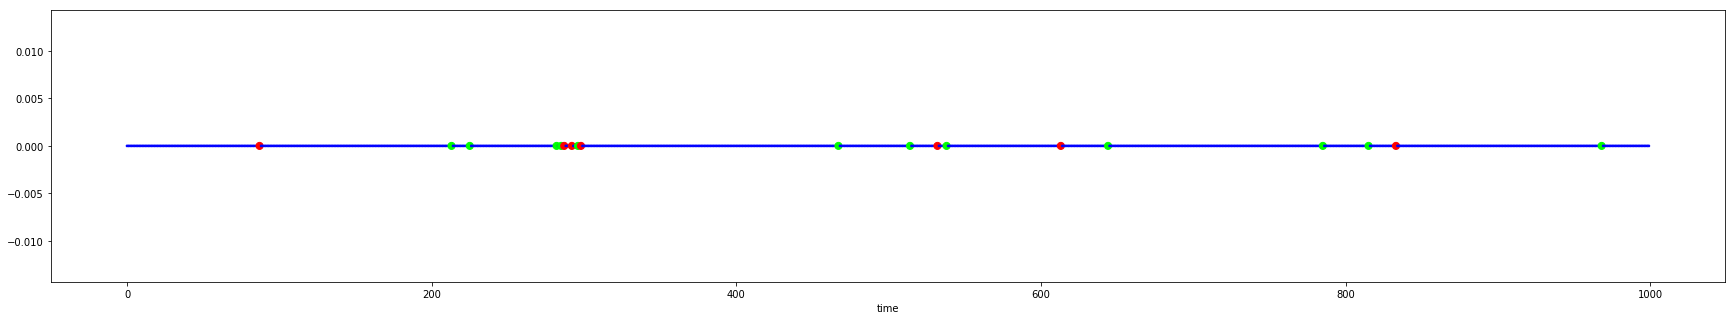

In [42]:
start = 0
end = 1000
plt.figure(figsize=(30, 5))
plt.scatter(
    [i for i in range((end-start))],
    [0 for i in range((end-start))],
    color=[(1 if i == 2 else 0, 1 if i == 0 else 0, 1 if i == 1 else 0) for i in labeling[start:end]],
    s=[(3 if i == 1 else 50) for i in labeling[start:end]]
)
plt.xlabel('time')

(array([ 2438.,     0.,     0.,     0.,     0., 38742.,     0.,     0.,
            0.,  2309.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

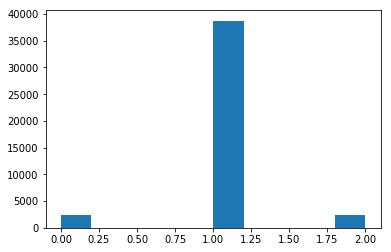

In [36]:
plt.hist(labeling)

# Data Formatting

## Labels
- HOLD: 1
- BUY: 0
- SELL: 2

## Data Format #1
| Column # | Description |
| --- | --- |
| 1 | close price t |
| 2 | trade volume t |
| 3 | close price t-1 |
| 4 | trade volume t-1 |
| 5 | close price t-2 |
| 6 | trade volume t-2 |
| 7 | close price t-3 |
| 8 | trade volume t-3 |
| 9 | close price t-4 |
| 10 | trade volume t-4 |
| 11 | close price t-5 |
| 12 | trade volume t-5 |

In [78]:
train = []
for t in range(period-1, len(price)):
    now = []
    for i in range(period):
        now.append(price.close[t-i])
        now.append(price.volume[t-i])
    train.append(now)
train = np.array(train)

In [86]:
timestep = 6
target_label = keras.utils.to_categorical(np.array([i+1 for i in action_frame.low]), num_classes=3)[timestep-1:]

## Data Format #2
| Column # | Description |
| --- | --- |
| 1 | close price t |
| 2 | close price t-1 |
| .. | .. | 
| 24 | close price t-23 |

### Data normalization

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [10]:
normalizer = StandardScaler()

In [11]:
price_normalized = normalizer.fit_transform(np.array(price.close)[:,np.newaxis])

C:\Users\yerla\.conda\envs\ml\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\yerla\.conda\envs\ml\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [14]:
timestep = 120
target_label = keras.utils.to_categorical(np.array([i+1 for i in action_frame.low]), num_classes=3)[timestep:]

In [15]:
data = []
for t in range(timestep, len(price_normalized)):
    data.append(price_normalized[t-timestep:t])
data = np.array(data)


### Reshape for Recurrent Layer input

In [16]:
data = data.reshape((data.shape[0], timestep, 1))

# Toy Data
It is to make sure that the RNN can recognize simple pattern

In [4]:
BUY = 0
HOLD = 1
SELL = 2
INITIAL_PRICE = 50000000

def generate_hold_pattern(last_price, length):
    return (
        np.array([last_price + np.random.normal(0, 10) for i in range(length)]), # balanced data
        np.array([HOLD for i in range(length)]) # balanced data
    )

def generate_buy_pattern(last_price, length):
    return (
        np.array([last_price + np.random.normal(i*10, 1) for i in range(length)]),
        np.array([BUY for i in range(length)])
    )

def generate_sell_pattern(last_price, length):
    return (
        np.array([last_price - np.random.normal(i*10, 1) for i in range(length)]),
        np.array([SELL for i in range(length)])
    )

In [55]:
price = np.array([])
label = np.array([])
current_price = INITIAL_PRICE
generators = [generate_hold_pattern, generate_buy_pattern, generate_sell_pattern]
for i in range(100):
    np.random.shuffle(generators)
    for f in generators:
        p, l = f(current_price, np.random.randint(15, 25))
        price = np.append(price, p)
        label = np.append(label, l)
        current_price = p[-1]

In [121]:
len(action_list)

2

# Real Data Preparation

## Labeling

In [8]:
from sklearn.preprocessing import StandardScaler

In [46]:
X = np.array(close)

In [79]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X.reshape(-1,1))
y_norm = X_norm[t_forward:]

C:\Users\yerla\.conda\envs\ml\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\yerla\.conda\envs\ml\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [80]:
timestep = t_forward
ts = []
for t in range(timestep, len(X_norm)):
    ts.append(X_norm[t-timestep:t])
ts = np.array(ts).T[0].T

In [81]:
ts.shape

(43459, 30)

In [82]:
y_norm[0]

array([-0.66093446])

In [83]:
test_split = len(ts) // 10 # percent
X_train = ts[:-test_split]
y_train = y_norm[:-test_split]
X_test = ts[-test_split:]
y_test = y_norm[-test_split:]

In [125]:
len(X_train)

39114

# Visualization

In [210]:
%matplotlib qt

plt_len = 30000
plt.figure(figsize=(40, 5))
plt.plot(X[:plt_len])
plt.figure(figsize=(40, 5))
plt.plot(profit[:plt_len])
plt.plot([0 for i in range(plt_len)])
plt.figure(figsize=(40, 5))
plt.scatter(
    [i for i in range((plt_len))],
    [0 for i in range((plt_len))],
    color=[(1 if i == 2 else 0, 1 if i == 0 else 0, 1 if i == 1 else 0) for i in y[:plt_len]],
    s=5
)

### RNN

In [123]:
X_train_rnn = X_train.reshape((X_train.shape[0], timestep, 1))
# target_label = keras.utils.to_categorical(np.array([i for i in label]), num_classes=3)[timestep:]

In [129]:
for i in range(1, len(X_train_rnn)):
    if len(X_train_rnn) % i == 0:
        print(i)

1
2
3
6
9
18
41
53
82
106
123
159
246
318
369
477
738
954
2173
4346
6519
13038
19557


### Others

In [36]:
train_data = data.T[0].T

In [41]:
train_data.shape

(40157, 20)

In [45]:
y_train[:20]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
      dtype=int64)

# Machine Learning Model: Generalized Linear Models

In [92]:
from sklearn.metrics import mean_absolute_error

In [97]:
from sklearn.linear_model import Lars

In [98]:
reg = Lars()

In [99]:
reg.fit(X_train, y_train)

Lars(copy_X=True, eps=2.220446049250313e-16, fit_intercept=True,
   fit_path=True, n_nonzero_coefs=500, normalize=True, positive=False,
   precompute='auto', verbose=False)

In [100]:
pred_train = scaler.inverse_transform(reg.predict(X_train))

In [101]:
mean_absolute_error(pred_train, scaler.inverse_transform(y_train))

17921.210259020303

In [102]:
pred_test = scaler.inverse_transform(reg.predict(X_test))

In [103]:
mean_absolute_error(pred_test, scaler.inverse_transform(y_test))

97555.37825431631

# Machine Learning Model: SVM

In [215]:
from sklearn.svm import SVR

In [237]:
clf = SVR()

In [ ]:
clf.fit(X_train, y_train)

C:\Users\yerla\.conda\envs\ml\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [91]:
clf.score(X, y)

0.8276157804459692

# Machine Learning Model: Gradient Boosting

In [109]:
from sklearn.ensemble import GradientBoostingClassifier

In [114]:
clf = GradientBoostingClassifier(n_estimators=200)

In [115]:
clf.fit(X, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [116]:
clf.score(X,y)

0.9060034305317324

# Machine Learning Model: RNN
4 Layers of Fully connected neural network + 1 softmax layer

In [114]:
from keras.models import Sequential
from keras.layers import Dense, Activation, SimpleRNN, BatchNormalization, LSTM

### Must set correct batch size
Length of training data must be divisible by batch size

In [130]:
correct_batch_size = 738

In [139]:
def generate_recurrent_layers(units, layers_count):
    return [SimpleRNN(units, return_sequences=True) for i in range(layers_count-1)] + [SimpleRNN(units)]

def generate_fully_connected_layers(units, layers_count, activation='sigmoid'):
    return [Dense(units, activation=activation) for i in range(layers_count)]

def generate_model(batch_size=1):
    return Sequential([
        LSTM(48, activation='linear', return_sequences=True, stateful=True, batch_input_shape=(batch_size, X_train_rnn.shape[1], X_train_rnn.shape[2])),
        BatchNormalization(),
        LSTM(40, activation='linear', return_sequences=True, stateful=True),
        BatchNormalization(),
        LSTM(32, activation='linear', return_sequences=True, stateful=True),
        BatchNormalization(),
        LSTM(24, activation='linear', return_sequences=True, stateful=True),
        BatchNormalization(),
        SimpleRNN(16, activation='linear',),
        Dense(8, activation='linear'),
        Dense(1, activation='linear')
    ])

def generate_simple_model(batch_size=1):
    return Sequential([
        LSTM(48, activation='linear', batch_input_shape=(batch_size, X_train_rnn.shape[1], X_train_rnn.shape[2])),
        Dense(1, activation='linear')
    ])

In [142]:
model = generate_simple_model(batch_size=correct_batch_size)
model.compile(optimizer='adam',
              loss='mean_squared_error')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (738, 48)                 9600      
_________________________________________________________________
dense_10 (Dense)             (738, 1)                  49        
Total params: 9,649
Trainable params: 9,649
Non-trainable params: 0
_________________________________________________________________


# Model Training

In [143]:
for i in range(5):
    model.fit(X_train_rnn, y_train, epochs=i+1, batch_size=correct_batch_size, verbose=1, shuffle=False, initial_epoch=i)
    model.reset_states()

Epoch 1/1
39114/39114 [==============================] - 5s 119us/step - loss: 0.1231
Epoch 2/2
39114/39114 [==============================] - 3s 82us/step - loss: 0.0254
Epoch 3/3
39114/39114 [==============================] - 3s 82us/step - loss: 0.0599
Epoch 4/4
39114/39114 [==============================] - 3s 82us/step - loss: 0.0048
Epoch 5/5
39114/39114 [==============================] - 3s 82us/step - loss: 0.2974


# Create Prediction Model

In [146]:
pred_model = generate_simple_model(batch_size=1)
pred_model.compile(optimizer='adam',
              loss='mean_squared_error')

In [147]:
training_weights = model.get_weights()
pred_model.set_weights(training_weights)

# Prediction using trained model

In [149]:
# online forecast
correct = 0
sample_point = np.random.randint(0, 14000)
for i in range(sample_point, sample_point+20):
    if i % 10 == 0:
        print('.', end='')
    testX, testy = data[i], target_label[i]
    testX = testX.reshape(1, timestep, 1)
    yhat = pred_model.predict(testX, batch_size=correct_batch_size)
    print(
        '>Expected={}, Predicted={}'.format(
            'buy' if all(testy == np.array([1,0,0])) else ('hold' if all(testy == np.array([0,1,0])) else 'sell'),
            'buy' if np.argmax(yhat) == 0 else ('hold' if np.argmax(yhat) == 1 else 'sell')
        )
    )
    if (np.argmax(testy) == np.argmax(yhat)):
        correct += 1
print()
print('sample accuracy =', correct/100)

>Expected=sell, Predicted=hold
>Expected=sell, Predicted=hold
>Expected=sell, Predicted=hold
>Expected=sell, Predicted=hold
>Expected=sell, Predicted=hold
>Expected=sell, Predicted=hold
>Expected=sell, Predicted=hold
.>Expected=sell, Predicted=hold
>Expected=hold, Predicted=hold
>Expected=hold, Predicted=hold
>Expected=hold, Predicted=hold
>Expected=hold, Predicted=hold
>Expected=hold, Predicted=hold
>Expected=hold, Predicted=hold
>Expected=hold, Predicted=hold
>Expected=hold, Predicted=hold
>Expected=hold, Predicted=hold
.>Expected=hold, Predicted=hold
>Expected=hold, Predicted=hold
>Expected=hold, Predicted=hold

sample accuracy = 0.12


In [405]:
np.argmax([1,2,3])

2

In [146]:
count1 = 0
for t in target_label:
    if all(t == np.array([1,0,0])):
        count1 += 1
count1/len(target_label)

0.3322267620020429